# Solución de la ecuación de Helmholtz usando PINNs

## Descripción del problema

Queremos resolver la siguiente ecuación:

\begin{align}
\Delta u  + k^{2}u = f(x, y)\quad \forall (x, y) \in \Omega\\
u(x, y) = 0\quad \forall (x, y) \in \partial \Omega
\end{align}

En el ejemplo tendremos $\Omega = (0, 1)^2$ y un termino fuente: 

$$
f(x,y) =  -a^2 \sin(a x)\sin(k y)
$$

donde  $a=2$ y $k=2$. La solución exacta es:

$$
u(x, y) =  \sin(a x)\sin(k y)
$$

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.stats import qmc
import torch.nn as nn
import time
from pyDOE import lhs

In [11]:
# Check GPU availability
device = 'cpu'#torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


# Solución exacta

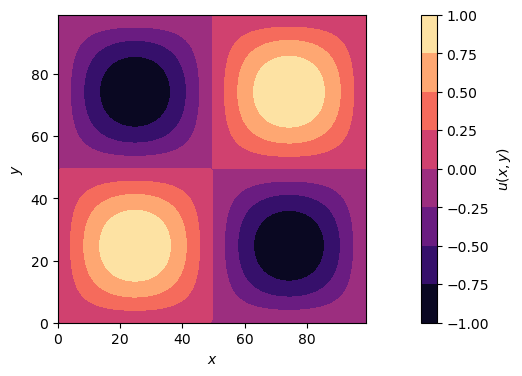

In [12]:
# Número de onda
a = 2
k = 2

# Número de muestras en x y y
dom_samples = 100
x = np.linspace(0, np.pi, dom_samples)
y = np.linspace(0, np.pi, dom_samples)

# Malla del dominio
X, Y = np.meshgrid(x, y)

def u_exact(x, y, k):
    return np.sin(a*x)*np.sin(k*y)

# Mostrar la solución exacta u(x, y)
plt.figure(figsize=(6, 4))  
img = plt.contourf(u_exact(X, Y, k), cmap='magma')
plt.colorbar(img, label='$u(x,y)$')   
plt.xlabel(r'$x$')   
plt.ylabel(r'$y$')
plt.axis("image")
plt.grid(False)

# Puntos de muestreo

In [20]:
# Define lower and upper bounds for the domain
lb = np.array([0.0, 0.0])
ub = np.array([np.pi, np.pi])  
N_b = 100  
N_f = 100 
c_f = lb + (ub-lb)*lhs(2, N_f)
x_f = torch.from_numpy(c_f[:, 0])
x_f.requires_grad = True
y_f = torch.from_numpy(c_f[:, 1])
y_f.requires_grad = True

 

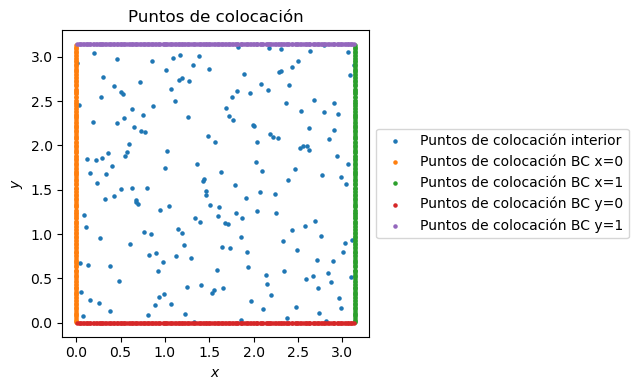

In [14]:
# Número de muestras para el dominio y los bordes
dom_samples = 200

# Estrategia de muestreo LHS (Latin Hypercube Sampling)
sampler = qmc.LatinHypercube(d=2)
sample = sampler.random(n=dom_samples)

# límites inferior y superior del dominio
l_bounds = [ 0, 0]
u_bounds = [ np.pi, np.pi]
domain_xt = qmc.scale(sample, l_bounds, u_bounds)

# tensores de torch
x_ten = torch.tensor(domain_xt[:, 0], requires_grad = True).float().reshape(-1,1).to(device)
y_ten = torch.tensor(domain_xt[:, 1], requires_grad = True).float().reshape(-1,1).to(device)

fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(domain_xt[:, 0], domain_xt[:, 1], s=5,
           label='Puntos de colocación interior')
ax.scatter(np.zeros_like(y_ten.cpu().detach().numpy()), y_ten.cpu().detach().numpy(),
           s=5, label='Puntos de colocación BC x=0')
ax.scatter(np.pi*np.ones_like(y_ten.cpu().detach().numpy()), y_ten.cpu().detach().numpy(),
           s=5, label='Puntos de colocación BC x=1')
ax.scatter(x_ten.cpu().detach().numpy(), np.zeros_like(x_ten.cpu().detach().numpy()),
           s=5, label='Puntos de colocación BC y=0')
ax.scatter(x_ten.cpu().detach().numpy(), np.pi*np.ones_like(x_ten.cpu().detach().numpy()),
           s=5, label='Puntos de colocación BC y=1')   
ax.set_title('Puntos de colocación')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$') 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.axis("image")
plt.tight_layout()

In [15]:
np.shape(y_ten)

torch.Size([200, 1])

# Definición de red neuronal 

In [16]:
# parámetros de entrenamiento
hidden_layers = [2, 150, 150, 150, 1]


# Definir una función de pérdida (Error Cuadrático Medio) para entrenar la red
MSE_func = nn.MSELoss()

# Definir una clase de red neuronal con capas y neuronas definidas por el usuario
class NeuralNetwork(nn.Module):
    
    def __init__(self, hlayers):
        super(NeuralNetwork, self).__init__()
        
        layers = []
        for i in range(len(hlayers[:-2])):
            layers.append(nn.Linear(hlayers[i], hlayers[i+1]))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hlayers[-2], hlayers[-1]))
        
        self.layers = nn.Sequential(*layers)
        self.init_params
        
    def init_params(self):
        """Xavier Glorot parameter initialization of the Neural Network
        """
        def init_normal(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight) # Xavier
        self.apply(init_normal)

    def forward(self, x):
        return self.layers(x)

In [17]:
# Crear una instancia de la red neuronal
u_pinn = NeuralNetwork(hidden_layers).to(device)
nparams = sum(p.numel() for p in u_pinn.parameters() if p.requires_grad)
print(f'Número de parámetros entrenables: {nparams}')
 


Número de parámetros entrenables: 45901


### Función de Pérdida Informada por la Física

In [18]:
# Definir la función de fuente f(x, y) para la ecuación de Poisson
def f_source(x, y, k):
    return -a**2*torch.sin(a*x)*torch.sin(k*y)

# Definición de la función gradiente que calcula la derivada parcial de una salida con respecto a una entrada
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, 
                        grad_outputs=torch.ones_like(outputs), 
                        create_graph=True,
                        retain_graph=True)[0]

# Definición de la función de pérdida para la Red Neuronal de Ecuaciones Diferenciales Parciales (PINN)
def PINN_poisson_Loss(forward_pass, x_ten, y_ten, 
             lambda1 = 1, lambda2 = 1, lambda3 = 1, lambda4 = 1):

    # Salida de la red neuronal y primeras y segundas derivadas
    domain = torch.cat([x_ten, y_ten], dim = 1)
    u = forward_pass(domain)
    u_x = grad(u, x_ten)
    u_xx = grad(u_x, x_ten)
    u_y = grad(u, y_ten)
    u_yy = grad(u_y, y_ten)
  
    # Definición de la pérdida de la Ecuación Diferencial Parcial (PDE)
    f_pde = u_xx + u_yy + k**2*u - f_source(x_ten, y_ten, k)
    PDE_loss = lambda1 * MSE_func(f_pde, torch.zeros_like(f_pde)) 
    
    # Definición de las condiciones de contorno y sus pérdidas correspondientes
    bcy1 = torch.cat([x_ten,torch.zeros_like(y_ten)], dim = 1)
    g_bcy1 = forward_pass(bcy1)
    bcy1_loss = lambda1 * MSE_func(g_bcy1, torch.zeros_like(g_bcy1))

    bcy2 = torch.cat([x_ten, torch.pi*torch.ones_like(y_ten)], dim = 1)
    g_bcy2 = forward_pass(bcy2)
    bcy2_loss = lambda2 * MSE_func(g_bcy2, torch.zeros_like(g_bcy2))

    bcx1 = torch.cat([torch.zeros_like(x_ten), y_ten], dim = 1)
    g_bcx1 = forward_pass(bcx1)
    bcx1_loss = lambda3 * MSE_func(g_bcx1, torch.zeros_like(g_bcx1))
    
    bcx2 = torch.cat([torch.pi*torch.ones_like(x_ten), y_ten], dim = 1)
    g_bcx2 = forward_pass(bcx2)
    bcx2_loss = lambda4 * MSE_func(g_bcx2, torch.zeros_like(g_bcx2))  
    
    # La función de pérdida total es la suma de todas las pérdidas
    return PDE_loss + bcx1_loss + bcx2_loss + bcy1_loss + bcy2_loss   

## Entrenamiento del modelo

In [19]:
# Inicialización de una lista para almacenar los valores de pérdida
loss_values = []

learning_rate = 0.01
training_iter = 2_00

# Definir el optimizador LBFGS
optimizer = torch.optim.LBFGS(u_pinn.parameters(), lr=learning_rate)

# Inicio del temporizador
start_time = time.time()

# Función de cierre requerida por LBFGS
def closure():
    optimizer.zero_grad()
    loss = PINN_poisson_Loss(u_pinn, x_ten, y_ten)
    loss.backward()
    return loss

# Entrenamiento de la red neuronal
for i in range(training_iter):
    
    # Ejecutar el optimizador LBFGS
    optimizer.step(closure)
    
    # Calcular la pérdida actual
    loss = PINN_poisson_Loss(u_pinn, x_ten, y_ten)
    
    # Añadir el valor actual de la pérdida a la lista
    loss_values.append(loss.item())
    
    # Imprimir cada 1000 iteraciones
    if i % 100 == 0:  
        print(f"Iteración {i}: Pérdida {loss.item()}")

# Parar el temporizador y calcular el tiempo transcurrido
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Tiempo de entrenamiento: {elapsed_time} segundos")

Iteración 0: Pérdida 4.160163879394531


KeyboardInterrupt: 

## Predicción

In [15]:
# Convertir los datos X e Y a tensores de PyTorch y cambiar su forma
X_ten = torch.tensor(X).float().reshape(-1, 1)
Y_ten = torch.tensor(Y).float().reshape(-1, 1)

# Concatenar los tensores X e Y en un solo tensor
domain_ten = torch.cat([X_ten,Y_ten], dim = 1).to(device)

# Generar predicciones usando la red neuronal y cambiar la forma para que coincida con la cuadrícula
U_pred = u_pinn(domain_ten).detach().cpu().numpy().reshape(X.shape)

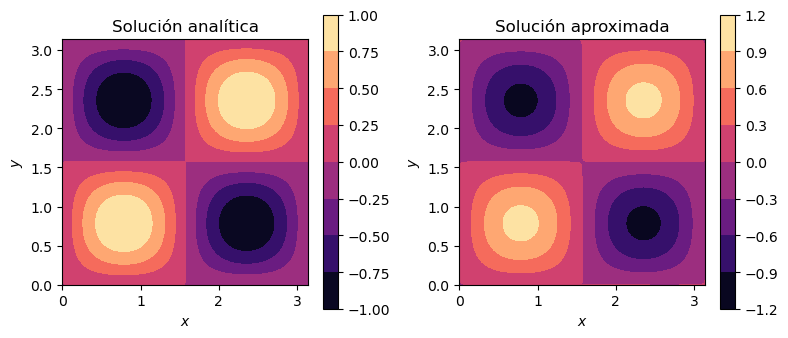

In [16]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.contourf(X, Y, u_exact(X, Y,k), cmap='magma')
plt.colorbar(shrink=0.8)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("Solución analítica")
plt.axis("image")
plt.grid(False)

plt.subplot(1, 2, 2)
plt.contourf(X, Y, U_pred, cmap='magma')
plt.colorbar(shrink=0.8)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("Solución aproximada")
plt.axis("image")
plt.grid(False)

plt.tight_layout()